In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')


In [2]:
def create_df(path):
    with open(path) as fi:
        data = fi.read()
    data = data.split('\n')


    # construct protein ID and fasta sequence
    prot_id = []
    seqs = []
    for i in range(1, len(data), 2):
        prot_id.append(data[i-1].replace(">", ""))
        seqs.append(data[i])
        
    df = {'Protein ID': prot_id, 'simple_fasta': seqs}
    df = pd.DataFrame(df)
    return df

In [3]:
# make dataframe from every temperature cluster
df1 = create_df('../data/Hyperthermophiliccd_hit_out')
df2 = create_df('../data/Mesophiliccd_hit_out')
df3 = create_df('../data/Thermophiliccd_hit_out')


# concatenate dataframes
frames = [df1, df2, df3]
df = pd.concat(frames)


# merge with filtered dataframe dataframe by Protein ID and simple_fasta
tm_per_seq = pd.read_csv('../data/filtered_data.csv')
filtered_seqs = pd.merge(df, tm_per_seq, how ='inner', on = ['Protein ID', 'simple_fasta'])


# read blind test data and exclude these sequences from train
test = pd.read_csv('../data/test_dataset.csv').iloc[:, 1:]
exclude_group = list(set(filtered_seqs['Protein ID']).intersection(set(test['Protein ID'])))
train = filtered_seqs.loc[~filtered_seqs['Protein ID'].isin(exclude_group)]

In [4]:
df = pd.concat([train, test])

In [5]:
y = df['Tm'].apply(lambda x: 1 if x <= 45 else 2 if (45 < x < 75) else 3)

In [6]:
df['Категория'] = y
df['Protein ID'] = df['Protein ID'].apply(lambda x: x.split('_')[0])

In [7]:
df.head()

,Protein ID,simple_fasta,Species,Tm,Категория
12,A0A0K2H9C7,MKRWLFAVSCAALLLLGGCTTKSEPKRAEPAKPAPRQEQPSKPPAE...,G.stearothermophilus,75.067,3
13,A0A0K2H563,MRIDILTLFPGMFSGVLNESILKKAQEKGAVDIRLIDFREFADNKH...,G.stearothermophilus,75.074,3
14,A0A0K2H825,MHIYRYEENPLITPEDVPPHHDGFEVIGAFNAGVARFQGEVLLLLR...,G.stearothermophilus,75.087,3
15,A0A0K2HAE8,MEEWPLRLFGWFFLSLLANALFASAEAAFSSASKARLRHYAEEHLH...,G.stearothermophilus,75.089,3
16,A0A0K2H9B8,MIERYTRPEMGAIWTEENRFKAWLEVELLACEAWAELGVIPKEDVR...,G.stearothermophilus,75.095,3


In [8]:
group_dict = {'charge' : ['R', 'H', 'K', 'D', 'E'], 'polar': ['S', 'T', 'N', 'Q'],  'cyctein': ['C'], 
             'glicin': ['G'], 'prolin' : ['P'], 'hydr' : ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W']}

In [9]:
ss_df = pd.read_csv('../data/ss_stat.csv')
ss_df.columns = ['Protein ID', 'disord', 'sheet', 'helix', 'sar']

In [10]:
df = df.merge(ss_df, how='inner', on='Protein ID')

In [11]:
df.Категория.value_counts()

2    10747
1     5812
3     1229
Name: Категория, dtype: int64

In [12]:
one = df[df.Категория==1].sample(n = 1229)
two = df[df.Категория==2].sample(n = 1229)
three = df[df.Категория==3]
overall = pd.concat([one, two, three])

In [13]:
overall.Категория.value_counts()

1    1229
2    1229
3    1229
Name: Категория, dtype: int64

In [14]:
overall.head()

,Protein ID,simple_fasta,Species,Tm,Категория,disord,sheet,helix,sar
3903,Q09974,MDLPQKKKFTESERAALAKKLDDDLDQFMEEMAARKSDKKEERKPF...,C.elegans,40.908,1,1491523534364142181543145441212,2222991741121647,528912221317141320532338357,30515
6509,R4YRB8,MNQIELNNITKRYPGCVANQSVELKVGAGEIHALLGENGAGKSTLM...,O.antarctica,40.702,1,1235724210109257332212957366252434211025732222,12126634115566109532411122156622,8661431316739329361414313167338,23816
2495,Q796Z1,MGYPKEGETIQIHSYKHNGLIHRIWNETTILKSTEMCVIGANDRTM...,B.subtilis,42.753,1,135334442351433,7136436892134,43101939,9816
4934,P54352,MGTETKSNSYTGQISTSGGNPKVMKDSLSLVRQTVNQQTLSLSQSN...,D.melanogaster,41.382,1,172298851242281722362444107135168176,25875524444,3304212343331313314161018233113173221,36880
6241,R4YSZ0,MREKITAIIASTLLFINVIFWCSILFLLTPIKFILPEIAVRKVMDP...,O.antarctica,38.335,1,12231052213441257722757,55113225810,274301057631373135634,17372


In [45]:
def stat_test(feature: str) -> float:
    s_1 = overall.loc[overall['Категория']==1].loc[:, feature].values
    s_2 = overall.loc[overall['Категория']==2].loc[:, feature].values
    s_3 = overall.loc[overall['Категория']==3].loc[:, feature].values
    
    _, pval_1 = stats.ttest_ind(a=s_1, b=s_3, equal_var=False)
    _, pval_2 = stats.ttest_ind(a=s_2, b=s_3, equal_var=False)
    _, pval_3 = stats.ttest_ind(a=s_1, b=s_2, equal_var=False)
    return pval_1, pval_2, pval_3

##### count physico-chemical group of aminoacid per sequence

In [46]:
def count_group_aa(group_dict, df):
    seqs = list(df.simple_fasta)
    for key in group_dict:
        stat = []
        for seq in seqs:
            a = 0
            for ch in group_dict[key]:
                a += seq.count(ch)
            stat.append(a)
        df[key] = np.array(stat)
    

In [47]:
count_group_aa(group_dict, overall)

In [48]:
def count_len(df): 
    seqs = list(df.simple_fasta)
    lengths =  np.array([len(seq) for seq in seqs])
    df['length_seq'] = lengths 

In [49]:
count_len(overall)

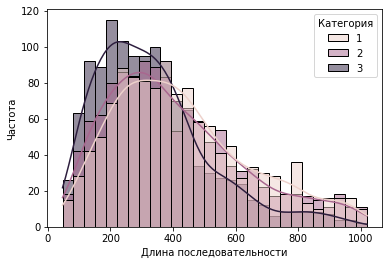

In [50]:
z = sns.histplot(overall, x='length_seq', hue='Категория',  kde=True);
z.set_xlabel('Длина последовательности')
z.set_ylabel('Частота')
plt.show()

In [51]:
pval = stat_test('length_seq')

In [52]:
pval

(9.17008029563751e-33, 1.1348030826565526e-19, 0.007120123270716726)

In [53]:
overall['charge_norm'] = overall['charge']/overall['length_seq']

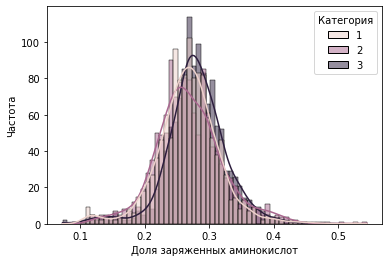

In [54]:
z = sns.histplot(overall, x='charge_norm', hue='Категория',  kde=True)
z.set_xlabel('Доля заряженных аминокислот')
z.set_ylabel('Частота')
plt.show()

In [55]:
p_value = stat_test('charge_norm')
p_value

(7.94775907411443e-10, 3.913823679557749e-07, 0.41406741790412804)

In [56]:
overall['polar_norm'] = overall['polar']/overall['length_seq']

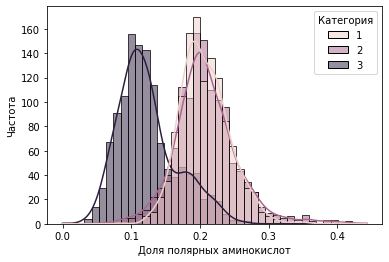

In [57]:
z = sns.histplot(overall, x='polar_norm', hue='Категория',  kde=True)
z.set_xlabel('Доля полярных аминокислот')
z.set_ylabel('Частота')
plt.show();

In [58]:
p_value = stat_test('polar_norm')
p_value

(0.0, 0.0, 0.4320021618487656)

In [30]:
overall['hydr_norm'] = overall['hydr']/overall['length_seq']

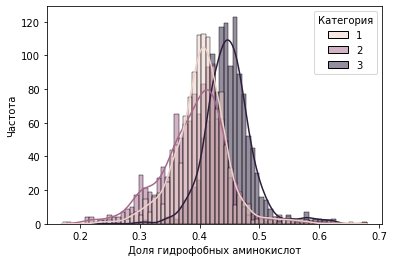

In [59]:
z = sns.histplot(overall, x='hydr_norm', hue='Категория',  kde=True)
z.set_xlabel('Доля гидрофобных аминокислот')
z.set_ylabel('Частота')
plt.show()

In [60]:
p_value = stat_test('hydr_norm')
p_value

(2.866113765891639e-132, 2.886448537511996e-160, 2.1875954372160782e-08)

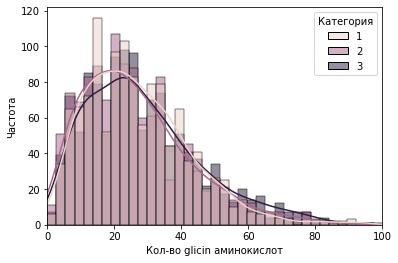

In [61]:
z = sns.histplot(overall, x='glicin', hue='Категория',  kde=True)
z.set_xlabel('Кол-во glicin аминокислот')
z.set_ylabel('Частота')
z.set_xlim(0, 100)
plt.show()

In [62]:
p_value = stat_test('glicin')
p_value

(0.015236662321536148, 0.002316066484525627, 0.45156268557675194)

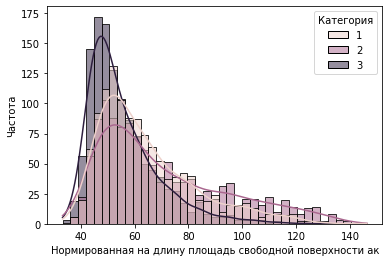

In [63]:
overall['sar_normalized'] = overall.sar/overall.length_seq # normalized sar
z = sns.histplot(data=overall, x='sar_normalized', hue='Категория',  kde=True)
z.set_xlabel('Нормированная на длину площадь свободной поверхности ак')
z.set_ylabel('Частота')
plt.show()

In [64]:
p_value = stat_test('sar_normalized')
p_value

(5.043699727553555e-42, 1.7255146063067236e-78, 2.7357218917272057e-13)